In [ ]:
import tensorflow as tf

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [ ]:
dataset = tf.keras.utils.get_file(
    "aclImdb_v1",
    url,
    extract= True,
    cache_dir ="."
)

84125825/84125825 [==============================] - 2s 0us/step


In [ ]:
import os
dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
os.listdir(dataset_dir)

['train', 'imdbEr.txt', 'README', 'test', 'imdb.vocab']

In [ ]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['labeledBow.feat',
 'pos',
 'unsupBow.feat',
 'urls_pos.txt',
 'unsup',
 'neg',
 'urls_neg.txt',
 'urls_unsup.txt']

In [ ]:
sample_file = os.path.join(train_dir, "pos/0_9.txt")
with open(sample_file) as f:
  print(f.read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


In [ ]:
import shutil
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [ ]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "datasets/aclImdb/train",
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed = 42,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Yorum:", text_batch.numpy()[i])
    print("Etiket:", label_batch.numpy()[i])

Yorum: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Etiket: 0
Yorum: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get int

In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "datasets/aclImdb/train",
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed = 42,
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "datasets/aclImdb/test",
    batch_size=32,
)

Found 25000 files belonging to 2 classes.


In [ ]:
import re
import string
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html=tf.strings.regex_replace(lowercase, "", "")
  return tf.strings.regex_replace(
      stripped_html, f"[{re.escape(string.punctuation)}]", "")

In [ ]:
vectorize_layer=tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens = 10000,
    output_sequence_length=250
)

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)

In [ ]:
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label= text_batch[0], label_batch[0]
print("Review: ", first_review)
print("Label: ", raw_train_ds.class_names[first_label])
print("Processed data: ", vectorize_text(first_review, first_label))

Review:  tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label:  neg
Processed data:  (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  87,   18,  259,    2,  223,    1,  566,   31,  228,   11, 2422,
           1,   52,   23,   26,  400,  250,   12,  308,  280,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
    

In [ ]:
print("345 --->", vectorize_layer.get_vocabulary()[345])
print("999 --->", vectorize_layer.get_vocabulary()[999])

345 ---> mind
999 ---> front


In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
max_features=10000
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features+1, 16),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer = "adam",
    metrics = tf.metrics.BinaryAccuracy(threshold=0.0)
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
625/625 [==============================] - 61s 93ms/step - loss: 0.6648 - binary_accuracy: 0.6953 - val_loss: 0.6166 - val_binary_accuracy: 0.7684
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5509 - binary_accuracy: 0.7983 - val_loss: 0.5010 - val_binary_accuracy: 0.8194
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4485 - binary_accuracy: 0.8419 - val_loss: 0.4235 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3817 - binary_accuracy: 0.8626 - val_loss: 0.3770 - val_binary_accuracy: 0.8598
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3388 - binary_accuracy: 0.8776 - val_loss: 0.3483 - val_binary_accuracy: 0.8658
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3085 - binary_accuracy: 0.8868 - val_loss: 0.3292 - val_binary_accuracy: 0.8706
Epoch 7/10
625/625 [==============================] - 3s 5ms/s

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 16s 20ms/step - loss: 0.3139 - binary_accuracy: 0.8712
Loss:  0.31393513083457947
Accuracy:  0.8711599707603455


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [ ]:
acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

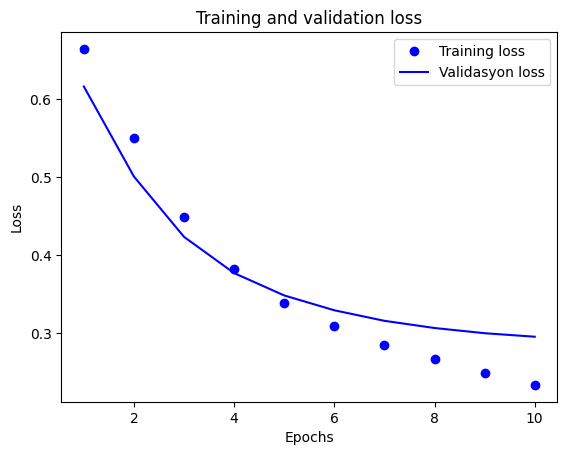

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(acc)+1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validasyon loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

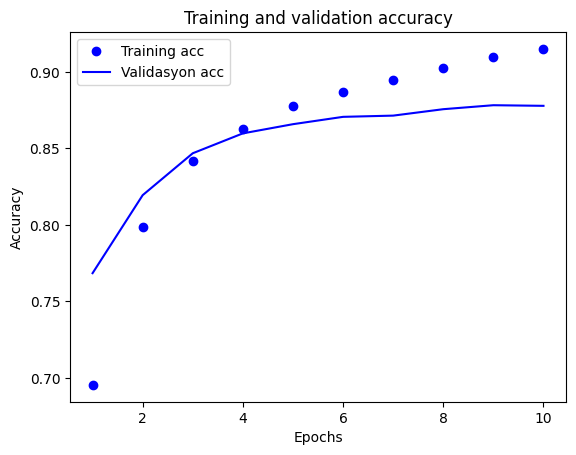

In [ ]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validasyon acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    tf.keras.layers.Activation("sigmoid")
])

In [ ]:
export_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer="adam",
    metrics = ["accuracy"]
)

In [ ]:
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 [==============================] - 16s 20ms/step - loss: 0.3139 - accuracy: 0.8712
0.8711599707603455


In [ ]:
examples = [
  "The movie was awesome!",
  "The movie was nice.",
  "The movie was awful..."
]

In [ ]:
export_model.predict(examples)

1/1 [==============================] - 0s 121ms/step


array([[0.5519097],
       [0.5179391],
       [0.3016434]], dtype=float32)